In [2]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering

In [3]:
timeMatrix = pd.read_csv('C:/Users/Aidan/OneDrive - Simon Fraser University (1sfu)/Garbage Route Optimization/timeMatrix.csv', index_col=0)

In [97]:
zones = pd.read_csv('C:/Users/Aidan/OneDrive - Simon Fraser University (1sfu)/Garbage Route Optimization/poco-allzones.csv', index_col=0)

In [107]:
zones = zones[(zones['Garbage Zone'] == 4) | (zones['Garbage Zone'] == 5)]

In [116]:
timeMatrix

,"1608 STELLA PL, Port Coquitlam, BC, Canada","1131 CASTLE CRES, Port Coquitlam, BC, Canada","1788 MARY HILL RD, Port Coquitlam, BC, Canada","1239 KNIGHTS CRT, Port Coquitlam, BC, Canada","2075 ROUTLEY AVE, Port Coquitlam, BC, Canada","3065 COAST MERIDIAN RD, Port Coquitlam, BC, Canada","2359 BEGBIE TERR, Port Coquitlam, BC, Canada","1012 LOMBARDY DR, Port Coquitlam, BC, Canada","1310 PRAIRIE AVE, Port Coquitlam, BC, Canada","3337 FIR ST, Port Coquitlam, BC, Canada",...,"3860 CLEMATIS CRES, Port Coquitlam, BC, Canada","762 EVANS PL, Port Coquitlam, BC, Canada","3445 EDINBURGH ST, Port Coquitlam, BC, Canada","1264 FRASER AVE, Port Coquitlam, BC, Canada","840 MUSKET TERR, Port Coquitlam, BC, Canada","2166 DRAWBRIDGE CLOSE, Port Coquitlam, BC, Canada","2956 PARANA PL, Port Coquitlam, BC, Canada","3055 SANDLEWOOD WAY, Port Coquitlam, BC, Canada","1382 RHINE CLOSE, Port Coquitlam, BC, Canada","735 PRAIRIE AVE, Port Coquitlam, BC, Canada"
"1608 STELLA PL, Port Coquitlam, BC, Canada",0.0,241.0,169.0,200.0,79.0,373.0,248.0,607.0,496.0,640.0,...,700.0,622.0,585.0,437.0,282.0,257.0,467.0,431.0,368.0,604.0
"1131 CASTLE CRES, Port Coquitlam, BC, Canada",241.0,0.0,318.0,125.0,177.0,539.0,125.0,773.0,662.0,806.0,...,866.0,788.0,751.0,603.0,157.0,55.0,633.0,597.0,534.0,770.0
"1788 MARY HILL RD, Port Coquitlam, BC, Canada",169.0,318.0,0.0,319.0,198.0,370.0,282.0,604.0,493.0,637.0,...,680.0,619.0,490.0,434.0,302.0,334.0,464.0,428.0,365.0,601.0
"1239 KNIGHTS CRT, Port Coquitlam, BC, Canada",200.0,125.0,319.0,0.0,136.0,498.0,132.0,732.0,621.0,765.0,...,825.0,747.0,710.0,562.0,166.0,141.0,592.0,556.0,493.0,729.0
"2075 ROUTLEY AVE, Port Coquitlam, BC, Canada",79.0,177.0,198.0,136.0,0.0,377.0,184.0,611.0,500.0,644.0,...,704.0,626.0,589.0,441.0,218.0,193.0,471.0,435.0,372.0,608.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"2166 DRAWBRIDGE CLOSE, Port Coquitlam, BC, Canada",257.0,55.0,334.0,141.0,193.0,555.0,141.0,789.0,678.0,822.0,...,882.0,804.0,767.0,619.0,173.0,0.0,649.0,613.0,550.0,786.0
"2956 PARANA PL, Port Coquitlam, BC, Canada",467.0,633.0,464.0,592.0,471.0,315.0,640.0,340.0,337.0,321.0,...,642.0,231.0,527.0,379.0,674.0,649.0,0.0,372.0,283.0,231.0
"3055 SANDLEWOOD WAY, Port Coquitlam, BC, Canada",431.0,597.0,428.0,556.0,435.0,156.0,604.0,193.0,99.0,226.0,...,483.0,260.0,368.0,65.0,638.0,613.0,372.0,0.0,203.0,190.0
"1382 RHINE CLOSE, Port Coquitlam, BC, Canada",368.0,534.0,365.0,493.0,372.0,145.0,541.0,379.0,268.0,412.0,...,472.0,446.0,357.0,209.0,575.0,550.0,283.0,203.0,0.0,376.0


In [113]:
timeMatrix.iloc[timeMatrix.index.isin(zones.index),timeMatrix.index.isin(zones.index)]

""


In [108]:
t = timeMatrix
# t = timeMatrix

In [8]:
from sklearn.preprocessing import normalize
t = normalize(t1)

In [70]:
from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)
model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', 
                                linkage='average')
model.fit_predict(t)
labels = model.labels_

In [71]:
clusters = pd.DataFrame({'cluster':labels, 'address':t.index})
clusters.groupby('cluster').nunique().sort_values(by='address')

,address
cluster,
3,3
1,108
4,381
2,709
0,799


In [29]:
len(labels)

9910

In [88]:
def adjustClusters(matrix,clusters, deviation, numElementsPerCluster):
    clusters = clusters.set_index('address')
    clusters['address'] = clusters.index
    
    numElementsInMin = clusters.groupby('cluster').nunique().sort_values(by='address').values[0][0]
    minCluster = clusters.groupby('cluster').nunique().sort_values(by='address').index[0]
    
    numElementsInMax = clusters.groupby('cluster').nunique().sort_values(by='address').values[-1][0]
    maxCluster = clusters.groupby('cluster').nunique().sort_values(by='address').index[-1]
    
    maxDeviation = not (numElementsInMax <= numElementsPerCluster + deviation and numElementsInMax >= numElementsPerCluster - deviation)
    minDeviation = not (numElementsInMin <= numElementsPerCluster + deviation and numElementsInMin >= numElementsPerCluster - deviation)
    
    while minDeviation or maxDeviation:
        
        # Determining the elements in the smallest and largest cluster
        minClusterElements = clusters[clusters['cluster'] ==  minCluster]['address']
        maxClusterElements = clusters[clusters['cluster'] ==  maxCluster]['address']      
          

        # Filtering the matrix so that the rows have only the min cluster elements and removing the min cluster
        # elements from the columns
        filteredMatrix = matrix.iloc[matrix.index.isin(minClusterElements.values),matrix.columns.isin(maxClusterElements.values)]
        
        # Determining the closest element to the min cluster
        closestElement = filteredMatrix.mean(axis=0).idxmin()
        
  
        clusters.loc[closestElement,'cluster'] = minCluster
        
        
        numElementsInMin = clusters.groupby('cluster').nunique().sort_values(by='address').values[0][0]
        minCluster = clusters.groupby('cluster').nunique().sort_values(by='address').index[0]

        numElementsInMax = clusters.groupby('cluster').nunique().sort_values(by='address').values[-1][0]
        maxCluster = clusters.groupby('cluster').nunique().sort_values(by='address').index[-1]



        maxDeviation = not (numElementsInMax <= numElementsPerCluster + deviation and numElementsInMax >= numElementsPerCluster - deviation)
        minDeviation = not (numElementsInMin <= numElementsPerCluster + deviation and numElementsInMin >= numElementsPerCluster - deviation)
        
        print(clusters.groupby('cluster').nunique().sort_values(by='address'))
        print("***********************************")

        
       



        
    return clusters
        
newClusters = adjustClusters(t,clusters, 10, 400)  
    
# newClusters = adjustClusters(t1,clusters, 3, 20)  

         address
cluster         
3              4
1            108
4            381
2            709
0            798
***********************************
         address
cluster         
3              5
1            108
4            381
2            709
0            797
***********************************
         address
cluster         
3              6
1            108
4            381
2            709
0            796
***********************************
         address
cluster         
3              7
1            108
4            381
2            709
0            795
***********************************
         address
cluster         
3              8
1            108
4            381
2            709
0            794
***********************************
         address
cluster         
3              9
1            108
4            381
2            709
0            793
***********************************
         address
cluster         
3             10
1            108
4 

         address
cluster         
3             59
1            108
4            381
2            709
0            743
***********************************
         address
cluster         
3             60
1            108
4            381
2            709
0            742
***********************************
         address
cluster         
3             61
1            108
4            381
2            709
0            741
***********************************
         address
cluster         
3             62
1            108
4            381
2            709
0            740
***********************************
         address
cluster         
3             63
1            108
4            381
2            709
0            739
***********************************
         address
cluster         
3             64
1            108
4            381
2            709
0            738
***********************************
         address
cluster         
3             65
1            108
4 

         address
cluster         
3            111
1            112
4            381
0            698
2            698
***********************************
         address
cluster         
1            112
3            112
4            381
2            697
0            698
***********************************
         address
cluster         
3            112
1            113
4            381
0            697
2            697
***********************************
         address
cluster         
1            113
3            113
4            381
2            696
0            697
***********************************
         address
cluster         
3            113
1            114
4            381
0            696
2            696
***********************************
         address
cluster         
1            114
3            114
4            381
2            695
0            696
***********************************
         address
cluster         
3            114
1            115
4 

         address
cluster         
1            141
3            141
4            381
2            668
0            669
***********************************
         address
cluster         
3            141
1            142
4            381
0            668
2            668
***********************************
         address
cluster         
1            142
3            142
4            381
2            667
0            668
***********************************
         address
cluster         
3            142
1            143
4            381
0            667
2            667
***********************************
         address
cluster         
1            143
3            143
4            381
2            666
0            667
***********************************
         address
cluster         
3            143
1            144
4            381
0            666
2            666
***********************************
         address
cluster         
1            144
3            144
4 

         address
cluster         
3            167
1            168
4            381
0            642
2            642
***********************************
         address
cluster         
1            168
3            168
4            381
2            641
0            642
***********************************
         address
cluster         
3            168
1            169
4            381
0            641
2            641
***********************************
         address
cluster         
1            169
3            169
4            381
2            640
0            641
***********************************
         address
cluster         
3            169
1            170
4            381
0            640
2            640
***********************************
         address
cluster         
1            170
3            170
4            381
2            639
0            640
***********************************
         address
cluster         
3            170
1            171
4 

         address
cluster         
1            194
3            194
4            381
2            615
0            616
***********************************
         address
cluster         
3            194
1            195
4            381
0            615
2            615
***********************************
         address
cluster         
1            195
3            195
4            381
2            614
0            615
***********************************
         address
cluster         
3            195
1            196
4            381
0            614
2            614
***********************************
         address
cluster         
1            196
3            196
4            381
2            613
0            614
***********************************
         address
cluster         
3            196
1            197
4            381
0            613
2            613
***********************************
         address
cluster         
1            197
3            197
4 

         address
cluster         
1            223
3            223
4            381
2            586
0            587
***********************************
         address
cluster         
3            223
1            224
4            381
0            586
2            586
***********************************
         address
cluster         
1            224
3            224
4            381
2            585
0            586
***********************************
         address
cluster         
3            224
1            225
4            381
0            585
2            585
***********************************
         address
cluster         
1            225
3            225
4            381
2            584
0            585
***********************************
         address
cluster         
3            225
1            226
4            381
0            584
2            584
***********************************
         address
cluster         
1            226
3            226
4 

         address
cluster         
1            251
3            251
4            381
2            558
0            559
***********************************
         address
cluster         
3            251
1            252
4            381
0            558
2            558
***********************************
         address
cluster         
1            252
3            252
4            381
2            557
0            558
***********************************
         address
cluster         
3            252
1            253
4            381
0            557
2            557
***********************************
         address
cluster         
1            253
3            253
4            381
2            556
0            557
***********************************
         address
cluster         
3            253
1            254
4            381
0            556
2            556
***********************************
         address
cluster         
1            254
3            254
4 

         address
cluster         
3            279
1            280
4            381
0            530
2            530
***********************************
         address
cluster         
1            280
3            280
4            381
2            529
0            530
***********************************
         address
cluster         
3            280
1            281
4            381
0            529
2            529
***********************************
         address
cluster         
1            281
3            281
4            381
2            528
0            529
***********************************
         address
cluster         
3            281
1            282
4            381
0            528
2            528
***********************************
         address
cluster         
1            282
3            282
4            381
2            527
0            528
***********************************
         address
cluster         
3            282
1            283
4 

         address
cluster         
1            309
3            309
4            381
2            500
0            501
***********************************
         address
cluster         
3            309
1            310
4            381
0            500
2            500
***********************************
         address
cluster         
1            310
3            310
4            381
2            499
0            500
***********************************
         address
cluster         
3            310
1            311
4            381
0            499
2            499
***********************************
         address
cluster         
1            311
3            311
4            381
2            498
0            499
***********************************
         address
cluster         
3            311
1            312
4            381
0            498
2            498
***********************************
         address
cluster         
1            312
3            312
4 

         address
cluster         
3            338
1            339
4            381
0            471
2            471
***********************************
         address
cluster         
1            339
3            339
4            381
2            470
0            471
***********************************
         address
cluster         
3            339
1            340
4            381
0            470
2            470
***********************************
         address
cluster         
1            340
3            340
4            381
2            469
0            470
***********************************
         address
cluster         
3            340
1            341
4            381
0            469
2            469
***********************************
         address
cluster         
1            341
3            341
4            381
2            468
0            469
***********************************
         address
cluster         
3            341
1            342
4 

         address
cluster         
3            368
1            369
4            381
0            441
2            441
***********************************
         address
cluster         
1            369
3            369
4            381
2            440
0            441
***********************************
         address
cluster         
3            369
1            370
4            381
0            440
2            440
***********************************
         address
cluster         
1            370
3            370
4            381
2            439
0            440
***********************************
         address
cluster         
3            370
1            371
4            381
0            439
2            439
***********************************
         address
cluster         
1            371
3            371
4            381
2            438
0            439
***********************************
         address
cluster         
3            371
1            372
4 

         address
cluster         
3            391
4            391
1            392
0            413
2            413
***********************************
         address
cluster         
4            391
1            392
3            392
2            412
0            413
***********************************
         address
cluster         
1            392
3            392
4            392
0            412
2            412
***********************************
         address
cluster         
3            392
4            392
1            393
2            411
0            412
***********************************
         address
cluster         
4            392
1            393
3            393
0            411
2            411
***********************************
         address
cluster         
1            393
3            393
4            393
2            410
0            411
***********************************
         address
cluster         
3            393
4            393
1 

In [89]:
newClusters

,cluster,address
address,,
"1608 STELLA PL, Port Coquitlam, BC, Canada",3,"1608 STELLA PL, Port Coquitlam, BC, Canada"
"1131 CASTLE CRES, Port Coquitlam, BC, Canada",2,"1131 CASTLE CRES, Port Coquitlam, BC, Canada"
"1788 MARY HILL RD, Port Coquitlam, BC, Canada",3,"1788 MARY HILL RD, Port Coquitlam, BC, Canada"
"1239 KNIGHTS CRT, Port Coquitlam, BC, Canada",2,"1239 KNIGHTS CRT, Port Coquitlam, BC, Canada"
"2075 ROUTLEY AVE, Port Coquitlam, BC, Canada",3,"2075 ROUTLEY AVE, Port Coquitlam, BC, Canada"
...,...,...
"976 MOODY CRT, Port Coquitlam, BC, Canada",2,"976 MOODY CRT, Port Coquitlam, BC, Canada"
"1696 MCPHERSON DR, Port Coquitlam, BC, Canada",4,"1696 MCPHERSON DR, Port Coquitlam, BC, Canada"
"3563 HANDLEY CRES, Port Coquitlam, BC, Canada",4,"3563 HANDLEY CRES, Port Coquitlam, BC, Canada"


In [90]:
coordinates = pd.read_csv('C:/Users/Aidan/OneDrive - Simon Fraser University (1sfu)/Garbage Route Optimization/locations.csv')
coordinates = coordinates.rename(columns={'Unnamed: 0':'address'})

In [91]:
newClusters = newClusters.reset_index(drop=True)

In [92]:
data = newClusters.merge(coordinates)

In [93]:
data

,cluster,address,lat,long
0,3,"1608 STELLA PL, Port Coquitlam, BC, Canada",49.245147,-122.775298
1,2,"1131 CASTLE CRES, Port Coquitlam, BC, Canada",49.233161,-122.777057
2,3,"1788 MARY HILL RD, Port Coquitlam, BC, Canada",49.249363,-122.780524
3,2,"1239 KNIGHTS CRT, Port Coquitlam, BC, Canada",49.236590,-122.779497
4,3,"2075 ROUTLEY AVE, Port Coquitlam, BC, Canada",49.240582,-122.773638
...,...,...,...,...
1995,2,"976 MOODY CRT, Port Coquitlam, BC, Canada",49.233112,-122.783081
1996,4,"1696 MCPHERSON DR, Port Coquitlam, BC, Canada",49.247734,-122.783028
1997,4,"3563 HANDLEY CRES, Port Coquitlam, BC, Canada",49.275559,-122.734420
1998,0,"1220 BARBERRY DR, Port Coquitlam, BC, Canada",49.265885,-122.747330


In [94]:
data.head()

,cluster,address,lat,long
0,3,"1608 STELLA PL, Port Coquitlam, BC, Canada",49.245147,-122.775298
1,2,"1131 CASTLE CRES, Port Coquitlam, BC, Canada",49.233161,-122.777057
2,3,"1788 MARY HILL RD, Port Coquitlam, BC, Canada",49.249363,-122.780524
3,2,"1239 KNIGHTS CRT, Port Coquitlam, BC, Canada",49.236590,-122.779497
4,3,"2075 ROUTLEY AVE, Port Coquitlam, BC, Canada",49.240582,-122.773638


In [95]:
import matplotlib.pyplot as plt

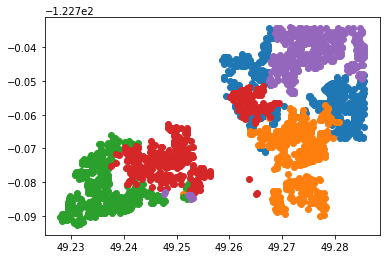

In [96]:
groups = data.groupby("cluster")

for name, group in groups:
    

    plt.plot(group["lat"], group["long"], marker="o", linestyle="", label=name)